# Self-Driving Car
## Project 5: Vehicle Detection
### Kimon Roufas

---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---
### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!




### Imports

In [1]:
# import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from collections import deque
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML

### Helper Functions

In [2]:
def display_two_images(img1, title1, img2, title2, save_file=None, cmaps=(None, None)):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title(title1, fontsize=40)
    ax1.imshow(img1, cmap=cmaps[0])
    ax2.set_title(title2, fontsize=40)
    ax2.imshow(img2, cmap=cmaps[1])
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    if save_file:
        plt.savefig(save_file)
    else:
        plt.show()
        
        
images = [
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg',
    './test_images/test6.jpg'
]
test_images = []
for fname in images:
    test_images.append(mpimg.imread(fname))
test1, test2, test3, test4, test5, test6 = test_images

In [3]:
def color_conversion(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
    return feature_image

    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
     
    
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


def extract_feature(feature_image, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    return hog_features


def extract_feature_image(feature_image, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Call get_hog_features() with vis=False, feature_vec=True
    hog_features = []
    hog_images = []
    if hog_channel == 'ALL':
        for channel in range(feature_image.shape[2]):
            hf, hi = get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=True)
            hog_features.append(hf)
            hog_images.append(hi)
        hog_features = np.ravel(hog_features)
    else:
        hog_features, hog_images = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    return (hog_features, hog_images)


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32,32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = color_conversion(image, cspace)

        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Get the HOG features
        hog_features = extract_feature(feature_image, cspace, orient, pix_per_cell, cell_per_block, hog_channel)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
#         all_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)        
#         features.append(all_features)

    return features


def load_image_names():
    # Divide up into cars and notcars
    cars = glob.glob('./training_images/vehicles/*/*.png')
    notcars = glob.glob('./training_images/non-vehicles/*/*.png')
    print('Number of images with cars: {0}, notcars: {1}'.format(len(cars), len(notcars)))
    return (cars, notcars)


# read in all the training samples of images with cars and without
cars, notcars = load_image_names()

Number of images with cars: 8792, notcars: 8968


### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook (or in lines # through # of the file called `some_file.py`).  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

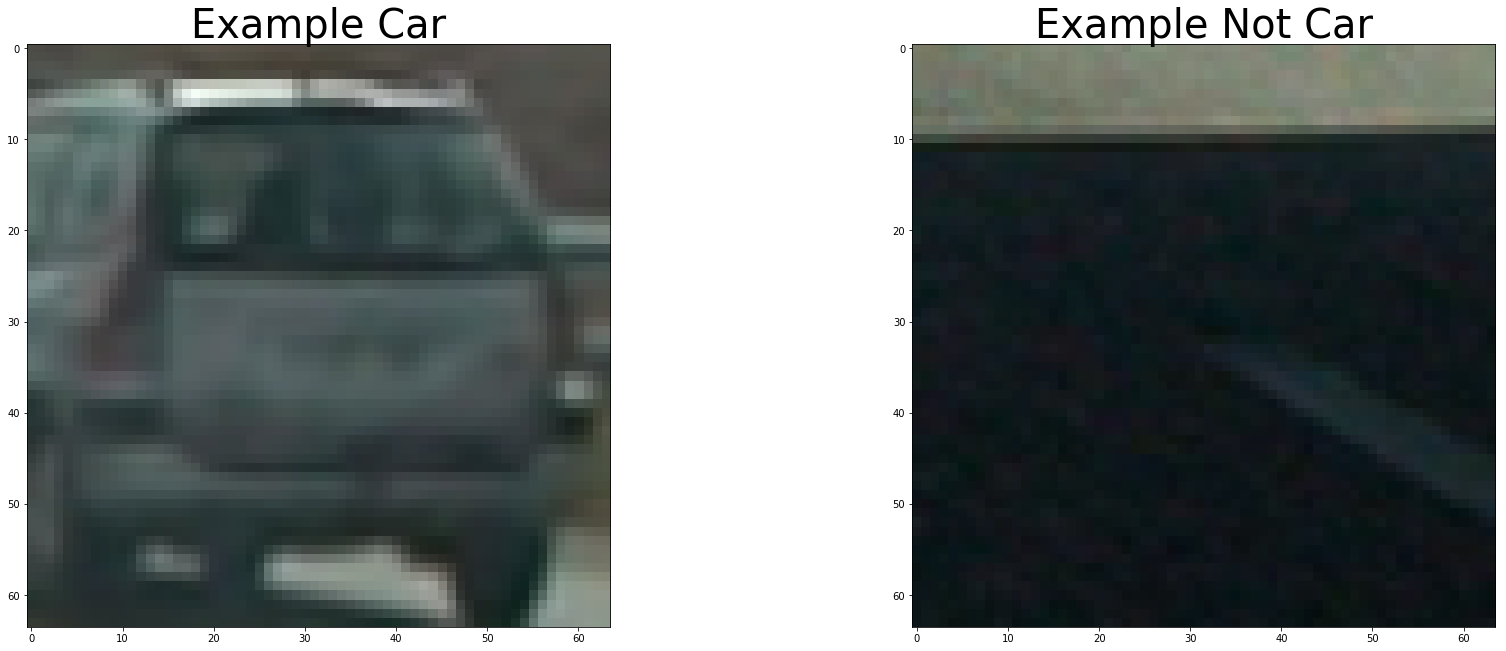

In [4]:
car0 = mpimg.imread(cars[0])
notcar0 = mpimg.imread(notcars[0])
# display_two_images(car0, 'Example Car', notcar0, 'Example Not Car', './output_images/car_not_car.png')
display_two_images(car0, 'Example Car', notcar0, 'Example Not Car')

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`). I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)`, `cells_per_block=(2, 2)`, shown for all 3 channels:




hog_images length: 3


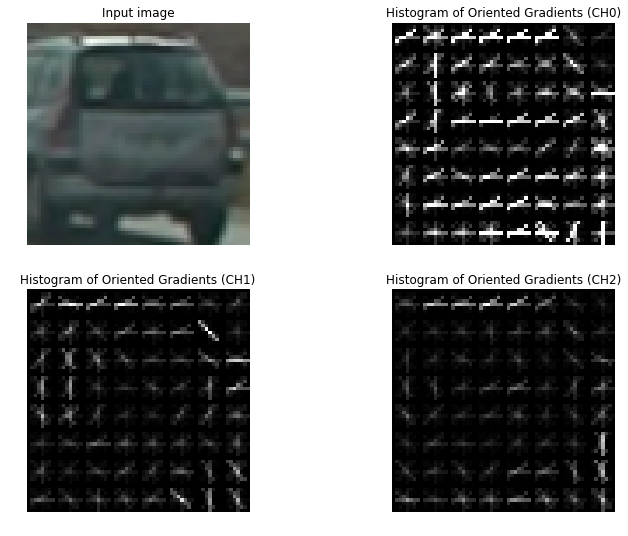

In [5]:
# from skimage.feature import hog
# from skimage import data, color, exposure
from skimage import exposure

### The parameters I tweaked:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32

feature_image = color_conversion(car0, colorspace)
hog_features, hog_images = extract_feature_image(feature_image, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

print('hog_images length: {0}'.format(len(hog_images)))


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 9))

ax1.axis('off')
ax1.imshow(car0)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

# Rescale histogram for better display
hog_image_rescaled0 = exposure.rescale_intensity(hog_images[0], in_range=(0, 0.02))
hog_image_rescaled1 = exposure.rescale_intensity(hog_images[1], in_range=(0, 0.02))
hog_image_rescaled2 = exposure.rescale_intensity(hog_images[2], in_range=(0, 0.02))


ax2.axis('off')
ax2.imshow(hog_image_rescaled0, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients (CH0)')
ax2.set_adjustable('box-forced')

ax3.axis('off')
ax3.imshow(hog_image_rescaled1, cmap=plt.cm.gray)
ax3.set_title('Histogram of Oriented Gradients (CH1)')
ax3.set_adjustable('box-forced')

ax4.axis('off')
ax4.imshow(hog_image_rescaled2, cmap=plt.cm.gray)
ax4.set_title('Histogram of Oriented Gradients (CH2)')
ax4.set_adjustable('box-forced')


plt.show()

#### 2. Explain how you settled on your final choice of HOG parameters.

In the next step, where I train an SVM using a set of images, I experimented with the feature extraction parameters until it looks like I got the best results. I then went to the previous section and used those in the example images to illustrate. Here is a summary:

```
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
```

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

Next I added some additional spatial color features with these parameters:

```
spatial_size = (32, 32)
hist_bins = 32
```

I trained a linear SVM using the code below. I use a sample of only 500 images to speed things along. The test accuracy is typically over 0.99 which is satisfactory.

In [6]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 32

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]


t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


80.4 Seconds to extract HOG features...
Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9636
11.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9896
My SVC predicts:      [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.]
0.00243 Seconds to predict 10 labels with SVC


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to use the HOG sub-sampling window search technique. Here are the parameters I used:
```
ystart = 400
ystop = 656
scale = 1.5
```
The code is shown below:

In [7]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = color_conversion(img_tosearch, cspace=colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bbox_list.append(bbox)
                cv2.rectangle(draw_img,bbox[0], bbox[1],(0,0,255),6) 
                
    return (draw_img, bbox_list)

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

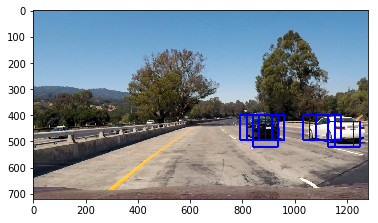

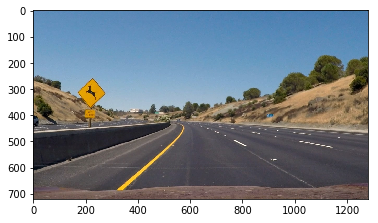

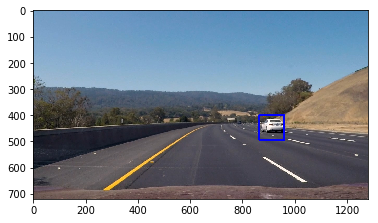

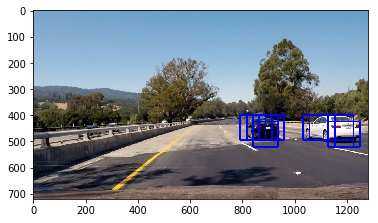

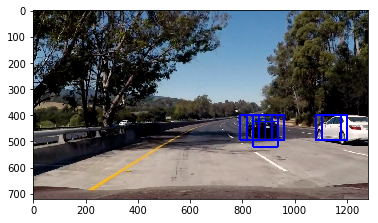

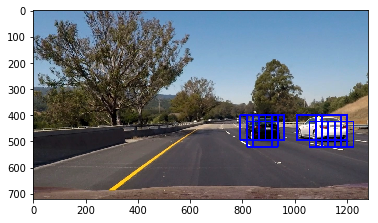

In [8]:
ystart = 400
ystop = 656
scale = 1.5

for test_image in test_images:
    out_img, bbox_list = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    plt.imshow(out_img)
    plt.show()

As you can see above, there are many false positives, and multiple bounding boxes on each vehicle. Below is the code using a heatmap with threshold to fix that. For my first attempt I applied the headmap/thresholding to each individual frame. This eliminated the vast majority of the false positives, and of course reduced the duplicates completely. However, a couple false positives did remain, so I decided to pursue using multiple frames and add the heatmap/thresholding to my video pipeline. I expect the additional data will make filtering easier. The resuls can be observed in the video further down.

In [9]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Pipeline (including multi-frame heatmap/thresholding)

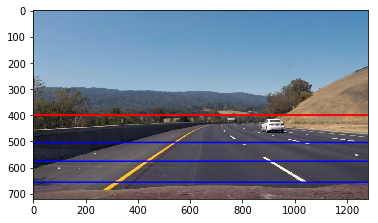

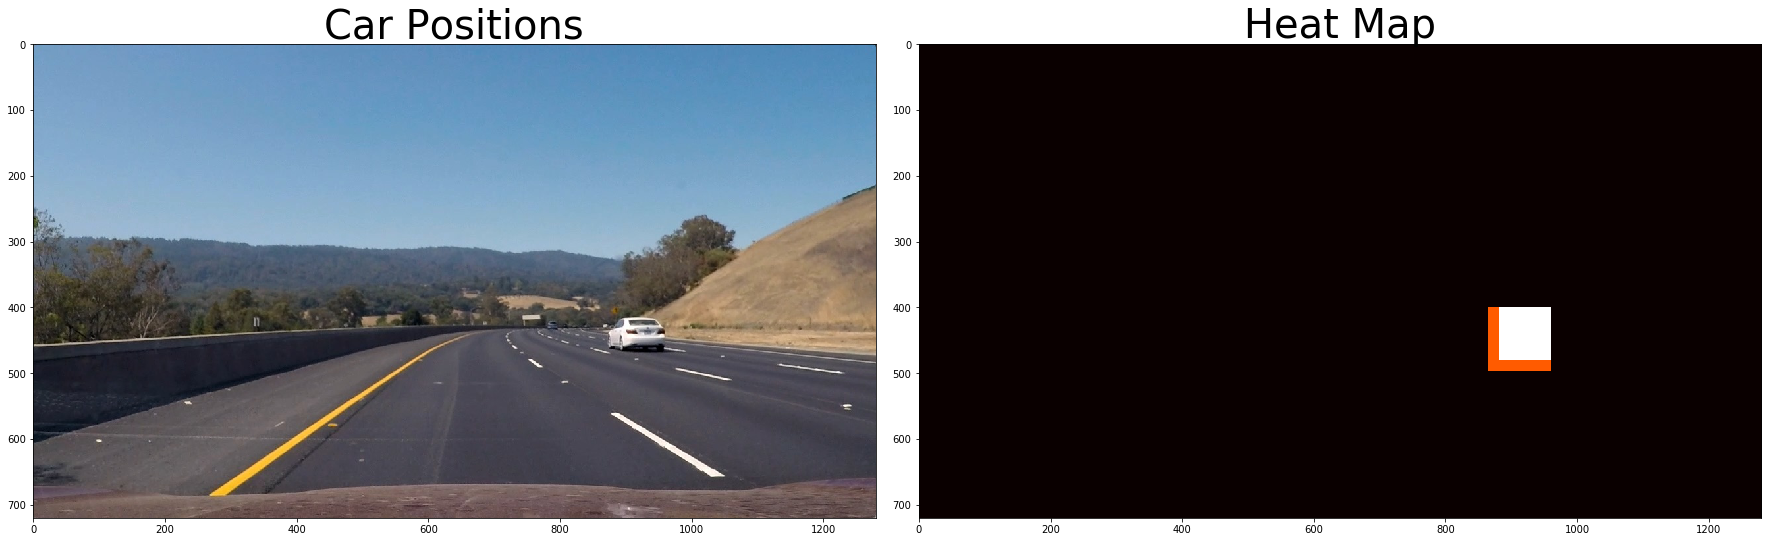

heatmap min: 0.0, max: 2.0


In [69]:
from pydash import flatten

# options:
# 1) collect all of the bboxes and then do the heatmap as a running sum of 5 frames
# 2) collect the labes from each frame and then add those to the next frame to boost the single frame heatmap

class Detection():
    def __init__(self):
        self.bboxes_deque = deque(maxlen=frame_averaging_length)
        self.heatmap_frames = []
#         self.histogram = []


def clear_state():
    global detection
    detection = Detection()
    
    
def vehicle_detection_pipeline(image, return_heatmap=False):
    bboxes = []
    for scale_set in scale_sets:
        out_img, bbox_list = find_cars(image, scale_set[0], scale_set[1], scale_set[2], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes.append(bbox_list)
    bboxes = flatten(bboxes)

#     out_img, bbox_list = find_cars(image, 400, 656, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    detection.bboxes_deque.append(bboxes)
    bboxes_deque = flatten(detection.bboxes_deque)
        
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes_deque)
    
    color_heatmap = np.copy(heat)
#     color_heatmap = np.copy(np.clip(heat, 0, 255))
#     color_heatmap = cv2.applyColorMap(color_heatmap.astype(np.uint8), cv2.COLORMAP_HOT)
#     color_heatmap = cv2.cvtColor(color_heatmap, cv2.COLOR_RGB2BGR)
    detection.heatmap_frames.append(color_heatmap)

#     heatmap_threshold = frame_averaging_length//2
    heatmap_threshold = 4
#     print('threshold: {0}'.format(heatmap_threshold))
    heat = apply_threshold(heat, heatmap_threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    if return_heatmap:
        return (draw_img, color_heatmap)
    else:
        return draw_img


# TEST CODE
#     scale_sets = [
#         (400, 500, 1.0),
#         (400, 550, 1.5),
#         (400, 600, 2.0)
#     ]

#     scale_sets = [
#         (400, 464, 0.5),
#         (416, 480, 0.5),
#         (400, 496, 0.75),
#         (432, 528, 0.75),
#         (400, 528, 1.0),
#         (432, 560, 1.0),
#         (400, 596, 1.75),
#         (464, 660, 1.75)
#     ]

#     scale_sets = [
#         (400, 500, 0.75),
#         (400, 560, 1.25),
#         (400, 660, 1.75)
#     ]

#     (375, 472, 0.75),


scale_sets = [
    (400, 504, 1.25),
    (400, 576, 1.5),
    (400, 656, 1.75)
]

max_x = test1.shape[1]
plt.imshow(test3)
for scale_set in scale_sets:
    plt.plot(np.ones(max_x)*scale_set[0], color='red')
    plt.plot(np.ones(max_x)*scale_set[1], color='blue')
plt.show()

frame_averaging_length = 12
clear_state()

# for test_image in test_images:
test_image = test3
clear_state()
draw_img, heatmap = vehicle_detection_pipeline(test_image, return_heatmap=True)
display_two_images(draw_img, 'Car Positions', heatmap, 'Heat Map', cmaps=(None, 'hot'))
print('heatmap min: {0}, max: {1}'.format(np.min(heatmap), np.max(heatmap)))

# draw_img, heatmap = vehicle_detection_pipeline(test1, return_heatmap=True)
# display_two_images(draw_img, 'Car Positions', heatmap, 'Heat Map', cmaps=(None, None))

# histogram = np.array(lanes.histogram)
# plt.imshow(histogram, interpolation='none', cmap='gnuplot')
# plt.show()

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

In [71]:
frame_averaging_length = 12
clear_state()


filename = 'project_video.mp4'
output_filename = 'output_videos/'+filename
heatmap_output_filename = 'output_videos/heatmap_'+filename

clip1 = VideoFileClip(filename)
# clip1 = VideoFileClip(filename).subclip(20, 25)
# clip1 = VideoFileClip(filename).subclip(26, 29)
# clip1 = VideoFileClip(filename).subclip(41, 43)
# clip1 = VideoFileClip(filename).subclip(0, 1)

output_clip = clip1.fl_image(vehicle_detection_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_filename, audio=False)

if (detection.heatmap_frames):
    heatmap_clip = ImageSequenceClip(detection.heatmap_frames, fps=25)
    heatmap_clip.write_videofile(heatmap_output_filename)
else:
    print('No heatmap frames to save!')

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [10:50<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 10min 27s, sys: 43.4 s, total: 11min 11s
Wall time: 10min 51s


IndexError: tuple index out of range


[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4


---


Here's a [link to my video result](./project_video.mp4)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]

### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]



---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

